<span style="font-size:3em;">US State Covid19 plots</span>

Note that you can manipulate the plots. You can...

* Single click on a label in the legend (e.g. "New York") and remove that line from the plot (single click again to bring it back)
* Double click on a label in the legend (e.g. "New York") and only show that line in the plot (double click again to bring back the others)
* Hover over a line to see its value. You can change what you see. Clicking on the top row third icon from the right will show a single value for the line closest to your pointer [this is useful]. Clicking on the top row second icon from the right will show all values (the default). 

In [1]:
using Covid19     # My package under development
using DataFrames, DataFramesMeta
using Pipe

# Get the data

In [2]:
updateJhuCSSE()

HEAD is now at 2c99a05 Merge pull request #2758 from CSSEGISandData/Update-6-25-Iowa
Already up to date.


Process(`git -C /Users/lyon/Development/Julia/Covid19/Covid19/src/../jhu_csse_covid19 pull`, ProcessExited(0))

In [3]:
confirmedByState = getCovid19Data(ConfirmedCases, StateLevel, 10);
categorical!(confirmedByState, :Province_State)
nrow(confirmedByState)

5824

In [4]:
deathsByState = getCovid19Data(Deaths, StateLevel, 3);
categorical!(deathsByState, :Province_State)
nrow(deathsByState)

5009

In [5]:
maximum(confirmedByState.Date)

2020-06-24

In [6]:
maximum(deathsByState.Date)

2020-06-24

# Look at the states with the most cases

In [7]:
function topLevels(df::DataFrame, n::Int, Level)
    tc = @pipe df |> 
               sort(_, [:Date, :Value], rev=(true, true)) |>  # Sort by date (reverse) and # cases (reverse)
               first(_, n) |>                                 # Get the n largest
               getindex(_, :, Level)                          # Get the values of the country/region/state name
    
    String.(tc)   # We want the names as strings, not categories
end

topLevels (generic function with 1 method)

In [48]:
topStatesCases = topLevels(confirmedByState, 10, :Province_State)

10-element Array{String,1}:
 "New York"
 "California"
 "New Jersey"
 "Illinois"
 "Texas"
 "Florida"
 "Massachusetts"
 "Pennsylvania"
 "Georgia"
 "Michigan"

In [49]:
topStatesDeaths = topLevels(deathsByState, 10, :Province_State)

10-element Array{String,1}:
 "New York"
 "New Jersey"
 "Massachusetts"
 "Illinois"
 "Pennsylvania"
 "Michigan"
 "California"
 "Connecticut"
 "Florida"
 "Louisiana"

In [50]:
push!(topStatesCases, "North Carolina");  # Add NC and AZ
push!(topStatesCases, "Arizona");

In [51]:
push!(topStatesDeaths, "North Carolina");  # Add NC and AZ
push!(topStatesDeaths, "Arizona");  # Add NC

In [52]:
# Restrict the datasets
confirmedByStateTop = @where(confirmedByState, in.(:Province_State, [topStatesCases]),  :Value_new .> 0);
deathsByStateTop    = @where(deathsByState,    in.(:Province_State, [topStatesDeaths]), :Value_new .> 0);

In [53]:
# Deal with the levels
function dealWithLevels!(df, theLevels)
    levels!(df.Province_State, theLevels)
    droplevels!(df.Province_State)
    ordered!(df.Province_State, true)
end

dealWithLevels!(confirmedByStateTop, topStatesCases)
dealWithLevels!(deathsByStateTop, topStatesDeaths);

In [54]:
# Set up plotting
using Plots, StatsPlots, Format
plotlyjs(size=(700,400))

# Format numbers with commas
fc(x) = format(x, commas=true, precision=0)
fcl(x) = format(x, commas=true)

fcl (generic function with 1 method)

In [55]:
lw = fill(2, (1, length(topStatesCases)))
lwConfirmed = lw
lwDeaths = lw
lwConfirmed[ topStatesCases .== "Illinois" ] .= 4
lwDeaths[ topStatesDeaths .== "Illinois" ] .= 4

1-element view(::Array{Int64,1}, [4]) with eltype Int64:
 4

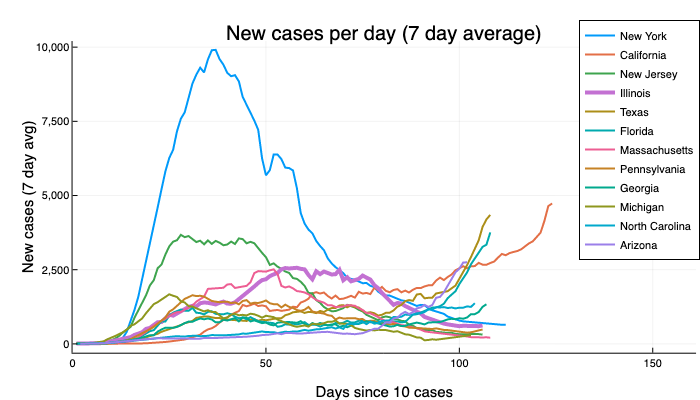

In [57]:
p = @df confirmedByStateTop plot(:daysSince, :Value_new_rolling7, group=:Province_State,
                             legend=:topright, yformatter=fc, lw=lwConfirmed,
                             xlimit=(0, maximum(:daysSince)*1.3),
                             title="New cases per day (7 day average)",
                             ylab="New cases (7 day avg)",
                             xlab="Days since 10 cases"
                             )

Let's remove NY, since that dominates.

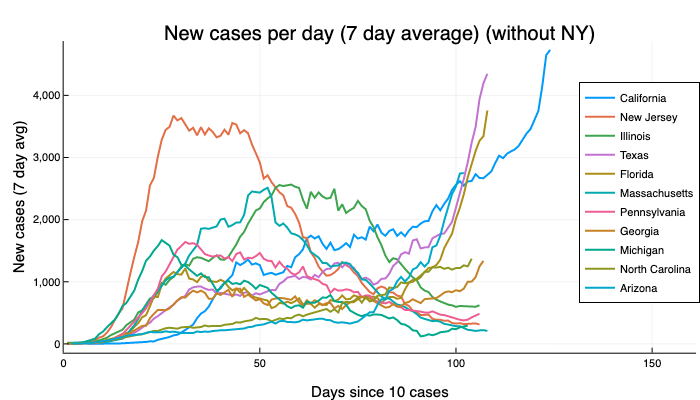

In [58]:
@df filter(:Province_State => !=("New York"), confirmedByStateTop) plot(:daysSince, :Value_new_rolling7, group=:Province_State,
                                 yformatter=fc, lw=2, xlimit=(0, maximum(:daysSince)*1.3), legend=:right,
                                 title="New cases per day (7 day average) (without NY)",
                                 ylab="New cases (7 day avg)",
                                 xlab="Days since 10 cases"
                                 )

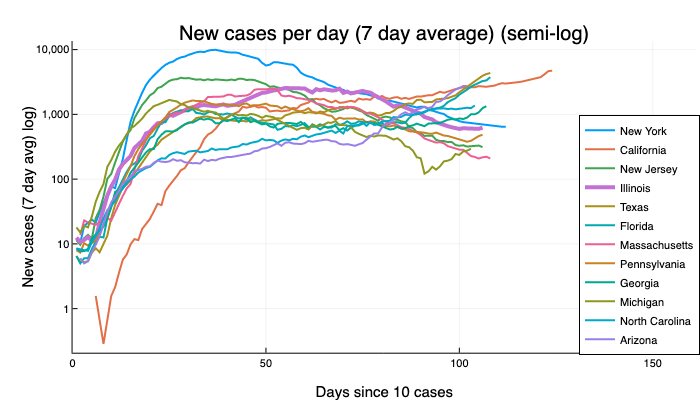

In [59]:
@df confirmedByStateTop plot(:daysSince, :Value_new_rolling7, group=:Province_State,
                             legend=:bottomright, yformatter=fc, lw=lwConfirmed, yscale=:log10,
                             xlimit=(0, maximum(:daysSince)*1.3),
                             title="New cases per day (7 day average) (semi-log)",
                             ylab="New cases (7 day avg) log)",
                             xlab="Days since 10 cases"
                            )

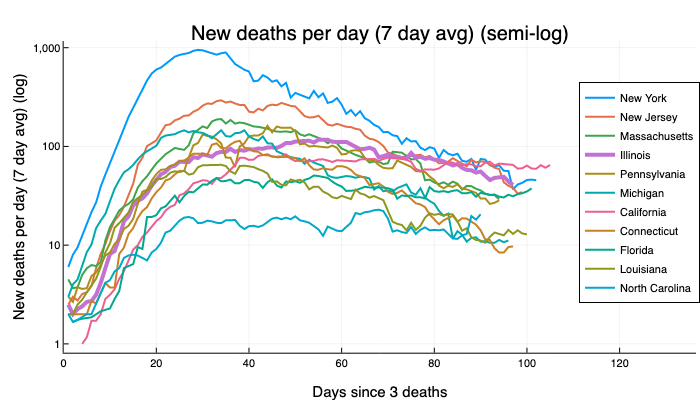

In [19]:
# A linear plot doesn't make much sense since NY dominates
@df deathsByStateTop plot(:daysSince, :Value_new_rolling7, group=:Province_State,
                          lw=lwDeaths, yscale=:log10, yformatter=fc, xlimit=(0, maximum(:daysSince)*1.3),
                          legend=:right,
                          title="New deaths per day (7 day avg) (semi-log)",
                          xlab="Days since 3 deaths", ylab="New deaths per day (7 day avg) (log)")

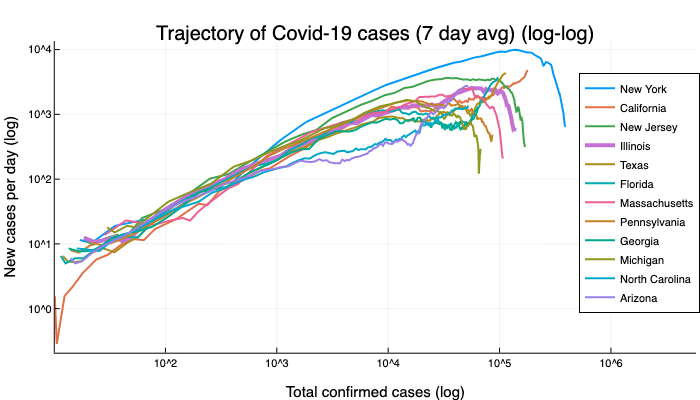

In [60]:
@df confirmedByStateTop plot(:Value_rolling7, :Value_new_rolling7, group=:Province_State, 
                          xscale=:log10, yscale=:log10, legend=:right, lw=lwConfirmed, 
                          xlim=(minimum(:Value_rolling7), maximum(:Value_rolling7)*15),
                          title="Trajectory of Covid-19 cases (7 day avg) (log-log)",
                          xlab="Total confirmed cases (log)", ylab="New cases per day (log)")



# Per capita plots (per 100,000 people)

In [61]:
using CSV, DataFrames

In [64]:
popDataPath = joinpath(@__DIR__, "../data", "nst-est2019-alldata.csv")
popData = CSV.read(popDataPath, select=["NAME", "POPESTIMATE2019"]);
rename!(popData, :POPESTIMATE2019 => :pop);

In [65]:
confirmedByStatePerCap = innerjoin(confirmedByState, popData, on=:Province_State=>:NAME);
deathsByStatePerCap = innerjoin(deathsByState, popData, on=:Province_State=>:NAME);

In [66]:
nrow(deathsByStatePerCap)

4780

In [67]:
confirmedByStatePerCap = @transform(confirmedByStatePerCap,
                            Value_perCap = :Value ./ :pop .* 100_000,
                            Value_rolling7_perCap = :Value_rolling7 ./ :pop .* 100_000,
                            Value_new_rolling7_perCap = :Value_new_rolling7 ./ :pop .* 100_000);
deathsByStatePerCap = @transform(deathsByStatePerCap,
                            Value_perCap = :Value ./ :pop .* 100_000,
                            Value_rolling7_perCap = :Value_rolling7 ./ :pop .* 100_000,
                            Value_new_rolling7_perCap = :Value_new_rolling7 ./ :pop .* 100_000);

Find the new top states

In [69]:
topStatesCasesPerCap = topLevels(confirmedByStatePerCap, 10, :Province_State);
push!(topStatesCasesPerCap, "North Carolina", "Arizona")

12-element Array{String,1}:
 "New York"
 "California"
 "New Jersey"
 "Illinois"
 "Texas"
 "Florida"
 "Massachusetts"
 "Pennsylvania"
 "Georgia"
 "Michigan"
 "North Carolina"
 "Arizona"

In [70]:
topStatesDeathsPerCap = topLevels(deathsByStatePerCap, 10, :Province_State);
push!(topStatesDeathsPerCap, "North Carolina", "Arizona")

12-element Array{String,1}:
 "New York"
 "New Jersey"
 "Massachusetts"
 "Illinois"
 "Pennsylvania"
 "Michigan"
 "California"
 "Connecticut"
 "Florida"
 "Louisiana"
 "North Carolina"
 "Arizona"

In [71]:
# Restrict the datasets
confirmedByStateTopPerCap = @where(confirmedByStatePerCap, in.(:Province_State, [topStatesCasesPerCap]),  :Value_new .> 0);
deathsByStateTopPerCap    = @where(deathsByStatePerCap,    in.(:Province_State, [topStatesDeathsPerCap]), :Value_new .> 0);

In [72]:
# Deal with levels
dealWithLevels!(confirmedByStateTopPerCap, topStatesCasesPerCap)
dealWithLevels!(deathsByStateTopPerCap, topStatesDeathsPerCap);

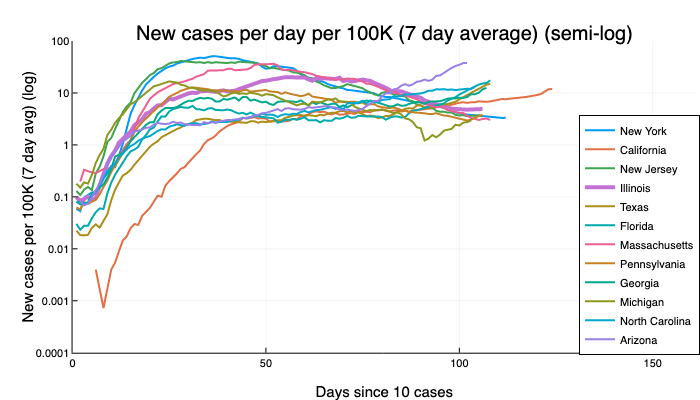

In [73]:
@df confirmedByStateTopPerCap plot(:daysSince, :Value_new_rolling7_perCap, group=:Province_State,
                             legend=:bottomright, yformatter=fcl, lw=lwConfirmed, yscale=:log10,
                             xlimit=(0, maximum(:daysSince)*1.3), ylimit=(0.0001, 100),
                             title="New cases per day per 100K (7 day average) (semi-log)",
                             ylab="New cases per 100K (7 day avg) (log)",
                             xlab="Days since 10 cases"
                            )

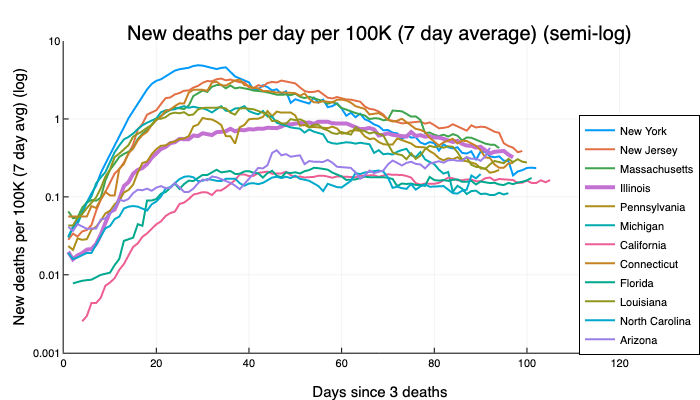

In [74]:
@df deathsByStateTopPerCap plot(:daysSince, :Value_new_rolling7_perCap, group=:Province_State,
                             legend=:bottomright, yformatter=fcl, lw=lwConfirmed, yscale=:log10,
                             xlimit=(0, maximum(:daysSince)*1.3), ylimit=(0.001, 10),
                             title="New deaths per day per 100K (7 day average) (semi-log)",
                             ylab="New deaths per 100K (7 day avg) (log)",
                             xlab="Days since 3 deaths"
                            )

# Largest growth
Let's look at the states that are experiencing the largest growth in the number of cases for the past two weeks.

In [75]:
function fastestGrowth(valueColumn)
    @pipe confirmedByStatePerCap |> 
          groupby(_, :Province_State) |>     # Separate by state
          combine(_, valueColumn => ( x -> x[end] - x[end-14]) => :twoWkGrowth) |>  # Compare latest value to two weeks ago
          sort(_, :twoWkGrowth, rev=true)
end

fastestGrowth (generic function with 1 method)

In [76]:
fg = fastestGrowth(:Value);

In [77]:
using PrettyTables

In [78]:
pretty_table(fg, ["State", "Two week growth in cases"], alignment=[:r, :c], backend=:html; formatters = ft_printf("%'d"))

State,Two week growth in cases
California,"56,210"
Texas,"47,355"
Florida,"41,643"
Arizona,"30,338"
North Carolina,"18,054"
Georgia,"15,401"
South Carolina,"12,138"
Alabama,"10,075"
New York,"9,510"
Tennessee,"9,305"


In [79]:
fgpc = fastestGrowth(:Value_perCap);

In [80]:
pretty_table(fgpc, ["State", "Two week growth in cases per 100K people"], alignment=[:r, :c], backend=:html; formatters = ft_printf("%'5.1f"))

State,Two week growth in cases per 100K people
Arizona,416.8
South Carolina,235.7
Arkansas,232.2
Alabama,205.5
Florida,193.9
Utah,184.7
Louisiana,181.7
North Carolina,172.1
Mississippi,166.0
Texas,163.3
